# A/B-тестирование

# Введение

A/B-тест один из самых точных  способов проверки гипотезы. Он способен помочь определить влияние изменений на конверсию. Поэтому, перед внедрением улучшенной системы рекомендаций, был проведен A/B-тест на новых пользователях. В данном анализе мы проведем оценку правильности теста и его результатов. 

## Техническое задание


- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

## Изучение данных

In [ ]:
pip install -U kaleido

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
from scipy import stats as st
from plotly import graph_objects as go
import re 
import math as mth
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.float_format = '{:,.1f}'.format

import plotly.io as pio
pio.renderers.default = "png"

In [ ]:
def datainfo(data):
  
    display(data)
    data.info()
    print()
    print('Дубликатов - ', ab_project_marketing_events.duplicated().sum())

`ab_project_marketing_events` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

In [ ]:
ab_project_marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')
datainfo(ab_project_marketing_events)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes

Дубликатов -  0


`final_ab_events` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

In [ ]:
final_ab_events = pd.read_csv('/datasets/final_ab_events.csv')
datainfo(final_ab_events)

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,100.0
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,10.0
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,5.0
3,96F27A054B191457,2020-12-07 04:02:40,purchase,5.0
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,5.0
...,...,...,...,...
440312,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
440313,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
440314,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
440315,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB

Дубликатов -  0


`final_ab_new_users` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

In [ ]:
final_ab_new_users = pd.read_csv('/datasets/final_ab_new_users.csv')
datainfo(final_ab_new_users)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
...,...,...,...,...
61728,1DB53B933257165D,2020-12-20,EU,Android
61729,538643EB4527ED03,2020-12-20,EU,Mac
61730,7ADEE837D5D8CBBD,2020-12-20,EU,PC
61731,1C7D23927835213F,2020-12-20,EU,iPhone


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB

Дубликатов -  0


`final_ab_participants` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

In [ ]:
final_ab_participants = pd.read_csv('/datasets/final_ab_participants.csv')
datainfo(final_ab_participants)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
...,...,...,...
18263,1D302F8688B91781,B,interface_eu_test
18264,3DE51B726983B657,A,interface_eu_test
18265,F501F79D332BE86C,A,interface_eu_test
18266,63FBE257B05F2245,A,interface_eu_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB

Дубликатов -  0


При изучении предоставленных данных не было обнаружено дублей. Во всех датафреймах, где есть даты, надо исправить типы данных этих самых дат. В `final_ab_events` есть пропуски, изучим их чуть позже.

## Подготовка данных

Поменяем типы данных для дат.

In [ ]:
ab_project_marketing_events['start_dt'] = pd.to_datetime(ab_project_marketing_events['start_dt'])
ab_project_marketing_events['finish_dt'] = pd.to_datetime(ab_project_marketing_events['finish_dt'])
final_ab_events['event_dt'] = pd.to_datetime(final_ab_events['event_dt'])
final_ab_new_users['first_date'] = pd.to_datetime(final_ab_new_users['first_date'])

Мы нашли пропуски в таблице `final_ab_events`в столбце где отображены дополнительные данные о совершенном событии, рассмотрим подробно к каким событиям есть дополнения:

In [ ]:
g = final_ab_events.loc[final_ab_events['details'].notna()]
g['event_name'].unique()

array(['purchase'], dtype=object)

Заполненные значения есть только в строках, зафиксировавших покупки(purchase).
<br> Посмотрим, количество заполненных значений и количество покупок, чтобы понять ко всем ли покупкам есть дополнительная информация.

In [ ]:
len(g[g['event_name'] =='purchase'])

62740

In [ ]:
len(g[g['details'].notna()])

62740

Количество строк совпадает, это приводит к выводу, что ко всем покупкам есть информация о цене покупки.

## Исследовательский анализ данных

Проверим соответствие дат прихода новых пользователей с датами, указанными в техническом задании. Напомню, что  дата запуска 2020-12-07 и дата остановки набора новых пользователей- 2020-12-21

In [ ]:
final_ab_new_users['first_date'].min()

Timestamp('2020-12-07 00:00:00')

In [ ]:
final_ab_new_users['first_date'].max()

Timestamp('2020-12-23 00:00:00')

Видимо новых пользователей прихватили и за 2020-12-22. Проверим регионы новых пользователей.

In [ ]:
final_ab_new_users.groupby(['region']).agg({'user_id': 'nunique'})

,user_id
region,
APAC,3153
CIS,3155
EU,46270
N.America,9155


In [ ]:
final_ab_new_users['user_id'].nunique()

61733

Всего у нас 61 733 новых пользователей и из них 46 270 из EU, именно они нас и интересуют.

In [ ]:
users = final_ab_participants.merge(final_ab_new_users, how='left', on = 'user_id')
users

,user_id,group,ab_test,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone
2,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac
3,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone
4,482F14783456D21B,B,recommender_system_test,2020-12-14,EU,PC
...,...,...,...,...,...,...
18263,1D302F8688B91781,B,interface_eu_test,2020-12-15,EU,PC
18264,3DE51B726983B657,A,interface_eu_test,2020-12-07,EU,Android
18265,F501F79D332BE86C,A,interface_eu_test,2020-12-17,EU,Mac
18266,63FBE257B05F2245,A,interface_eu_test,2020-12-20,EU,Android


In [ ]:
users.groupby(['region']).agg({'user_id': 'nunique'})

,user_id
region,
APAC,72
CIS,55
EU,16316
N.America,223


In [ ]:
users.groupby(['ab_test','group']).agg({'user_id': 'count'})

user_id
ab_test                 group         
interface_eu_test       A         5831
                        B         5736
recommender_system_test A         3824
                        B         2877

In [ ]:
final_ab_participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

Параллельно с нашим тестом, видимо проводили другой тест, т.к. в таблице `final_ab_participants`, в названии теста есть еще некий `interface_eu_test`.
<br>Проверим пересечения пользователей в тестах

In [ ]:
test_2 = users[users['ab_test'] == 'interface_eu_test']
test_1 = users[users['ab_test'] == 'recommender_system_test']
test_2_B = test_2.query('group == "B"').user_id.unique()
test_1.query('user_id in @ test_2_B').groupby(['ab_test','group']).agg({'user_id': 'count'})

user_id
ab_test                 group         
recommender_system_test A          439
                        B          344

Исключим пользователей B группы параллельного теста из нашего теста.

In [ ]:
test_1 = test_1.query('user_id not in @ test_2_B')
test_1.groupby(['ab_test','group']).agg({'user_id': 'count'})

user_id
ab_test                 group         
recommender_system_test A         3385
                        B         2533

В нашем ТЗ есть информация о том, что тест проводится на пользователях *EU*, поэтому исключим пользователей из других регионов.

In [ ]:
test_1 = test_1[test_1['region'] == 'EU']
test_1

,user_id,group,ab_test,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone
2,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac
3,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone
4,482F14783456D21B,B,recommender_system_test,2020-12-14,EU,PC
...,...,...,...,...,...,...
6346,7C5C12FA1B5AB710,A,recommender_system_test,2020-12-21,EU,Android
6347,91C3969B8A72B908,B,recommender_system_test,2020-12-09,EU,Android
6348,E26F13A65CEAC6EA,A,recommender_system_test,2020-12-17,EU,Mac
6349,95401934D6D6D4FC,B,recommender_system_test,2020-12-13,EU,iPhone


Пользователей в тесте осталось 5 568. Проверим на данном этапе сколько пользователей из *EU* попали в наш тест.

In [ ]:
test_1['user_id'].count()/final_ab_new_users.loc[final_ab_new_users['region'] == "EU",['user_id']].nunique()*100

user_id   12.0
dtype: float64

Всего 12%, на 3% меньше, чем хотелось бы.

In [ ]:
test_1.groupby(['ab_test','group']).agg({'user_id': 'count'})

user_id
ab_test                 group         
recommender_system_test A         3195
                        B         2373

Объединим наших пользователей с событиями.

In [ ]:
df = test_1.merge(final_ab_events, how='right', on = 'user_id')
df

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details
0,E1BDDCE0DAFA2679,NaN,NaN,NaT,NaN,NaN,2020-12-07 20:22:03,purchase,100.0
1,7B6452F081F49504,NaN,NaN,NaT,NaN,NaN,2020-12-07 09:22:53,purchase,10.0
2,9CD9F34546DF254C,NaN,NaN,NaT,NaN,NaN,2020-12-07 12:59:29,purchase,5.0
3,96F27A054B191457,NaN,NaN,NaT,NaN,NaN,2020-12-07 04:02:40,purchase,5.0
4,1FD7660FDF94CA1F,NaN,NaN,NaT,NaN,NaN,2020-12-07 10:15:09,purchase,5.0
...,...,...,...,...,...,...,...,...,...
440312,245E85F65C358E08,NaN,NaN,NaT,NaN,NaN,2020-12-30 19:35:55,login,NaN
440313,9385A108F5A0A7A7,NaN,NaN,NaT,NaN,NaN,2020-12-30 10:54:15,login,NaN
440314,DB650B7559AC6EAC,NaN,NaN,NaT,NaN,NaN,2020-12-30 10:59:09,login,NaN
440315,F80C9BDDEA02E53C,NaN,NaN,NaT,NaN,NaN,2020-12-30 09:53:39,login,NaN


Всего у нас 440317 действий. В столбце `group` есть *NaN* и судя по всему их много.

Удалим строки, где в столбце `group` есть *NaN*, таким образом мы уберем действия, которые не вошли в тест.

In [ ]:
df = df[df['group'].notna()]
df

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details
5,831887FE7F2D6CBA,A,recommender_system_test,2020-12-07,EU,Android,2020-12-07 06:50:29,purchase,5.0
17,3C5DD0288AC4FE23,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 19:42:40,purchase,5.0
58,49EA242586C87836,B,recommender_system_test,2020-12-07,EU,iPhone,2020-12-07 06:31:24,purchase,100.0
71,2B06EB547B7AAD08,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 21:36:38,purchase,5.0
74,A640F31CAC7823A6,B,recommender_system_test,2020-12-07,EU,PC,2020-12-07 18:48:26,purchase,5.0
...,...,...,...,...,...,...,...,...,...
440236,E5589EAE02ACD150,A,recommender_system_test,2020-12-20,EU,Mac,2020-12-29 22:17:08,login,NaN
440239,D21F0D4FDCD82DB2,A,recommender_system_test,2020-12-20,EU,iPhone,2020-12-29 02:17:00,login,NaN
440267,553BAE96C6EB6240,A,recommender_system_test,2020-12-20,EU,Android,2020-12-29 14:09:14,login,NaN
440281,DD4352CDCF8C3D57,B,recommender_system_test,2020-12-07,EU,Android,2020-12-30 12:42:56,login,NaN


In [ ]:
df.groupby(['ab_test','group']).agg({'user_id': 'nunique'})

user_id
ab_test                 group         
recommender_system_test A         2279
                        B          771

После чистки участников теста по условиям у нас осталось всего 3050 пользователей в тесте и действий осталось меньше половины. Возможны часть данных где-то потеряли. <br>Пункты по количеству участников - 6000 и процента от новых пользователей из ТЗ не соблюдаются. Пользователей в тесте 6.6% от новых пользователей из EU.
<br> Посмотрим, первую дату у пользователей, что бы соотнести из с рамками из ТЗ.

In [ ]:
df['first_date'].max()

Timestamp('2020-12-21 00:00:00')

In [ ]:
df['first_date'].min()

Timestamp('2020-12-07 00:00:00')

По периоду набора новых пользователей *ТЗ соблюдается*.
<br> Проверим даты проведения всего теста по оставшимся пользователям.

In [ ]:
df['event_dt'].max()

Timestamp('2020-12-30 12:42:57')

In [ ]:
df['event_dt'].min()

Timestamp('2020-12-07 00:05:57')

Дата последнего события по нашим пользователям это 30.12.2020. Хотя дата остановки теста планировалась 04.01.2022. из-за того, что действия заканчиваются 30.12.2020, а не 04.01.2021 как планировалось.
<br>Найдем пользователей, которые не входят в 14ти-дневный период тестирования (из ТЗ) из-за того, что действия заканчиваются 30.12.2020, а не 04.01.2021 как планировалось.

In [ ]:
user_after  = df.query('event_name == "login" and first_date > "2020-12-16"')
user_after['user_id'].nunique()

1375

Прилично, 45% от всех наших тестируемых.
<br>Проверим маркетинговые события на момент пересечения с нашими датами проведения теста.

In [ ]:
ab_project_marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


Выберем рекламные кампании, которые проводились на территории *EU* и проводились в период нашего теста.

In [ ]:
marketing_ev = ab_project_marketing_events[ab_project_marketing_events['regions'].str.contains(r'\bEU')]
marketing_ev[marketing_ev['start_dt'].between("2020-12-07", "2021-01-04", inclusive = True) ]

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


Проверим еще финальную дату рекламной кампании

In [ ]:
marketing_ev[marketing_ev['finish_dt'].between("2020-12-07", "2021-01-04", inclusive = True) ]

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


Вот оно! Проводить тест под новый год - такое себе занятие.

Добавим столбец с датой события с исключением времени.

In [ ]:
pd.set_option('chained_assignment', None)
df['event_day'] = pd.to_datetime(df['event_dt']).dt.date
df['event_day'] = pd.to_datetime(df['event_day'])

Построим функцию для вывода гистограмм с распределением по времени событий теста.

In [ ]:
def hist(data):
    plt.title('Гистограмма распределения всех событий во времени')
    data['event_dt'].hist(bins=14*24, figsize=(14, 5))
    
    
    data.loc[df['event_name'] == 'login',['event_dt']].hist(bins=14*24, figsize=(14, 5))
    plt.title('Гистограмма распределения во времени события "login"')
    
    data.loc[df['event_name'] == 'product_page',['event_dt']].hist(bins=14*24, figsize=(14, 5))
    plt.title('Гистограмма распределения во времени события "product_page"')
    
    data.loc[df['event_name'] == 'product_cart',['event_dt']].hist(bins=14*24, figsize=(14, 5))
    plt.title('Гистограмма распределения во времени события "product_cart"') 
    
    data.loc[df['event_name'] == 'purchase',['event_dt']].hist(bins=14*24, figsize=(14, 5))
    plt.title('Гистограмма распределения во времени события "purchase"') 
    
    plt.show()

Вызовем функцию.

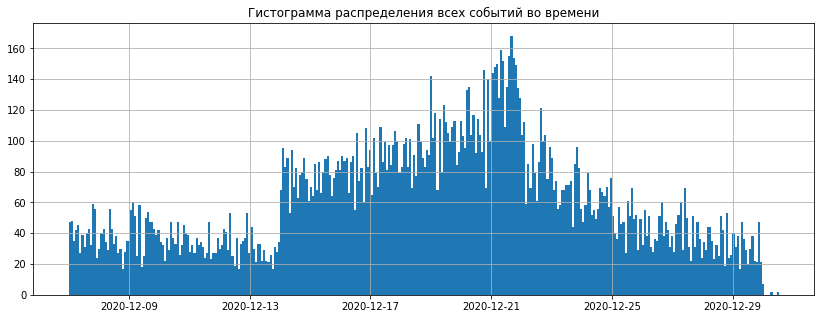

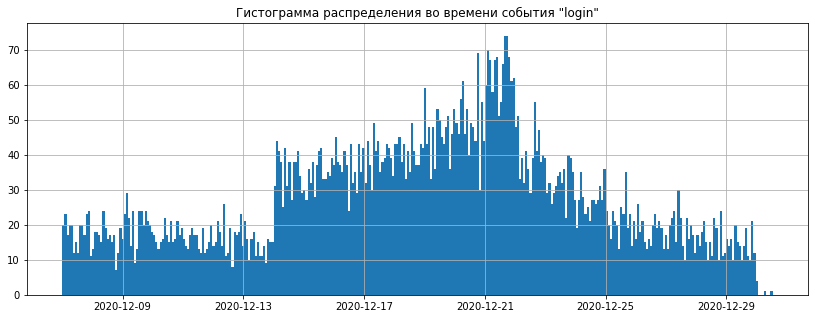

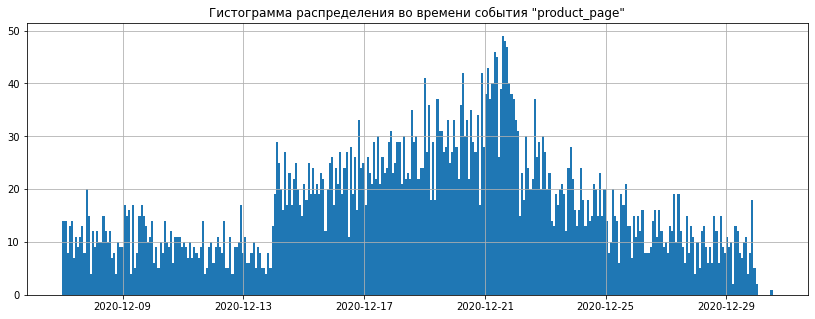

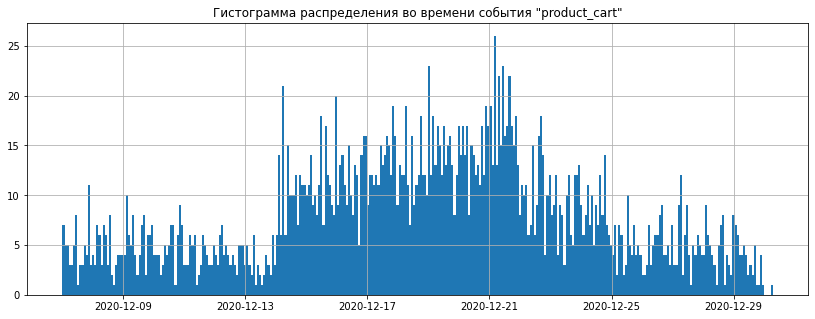

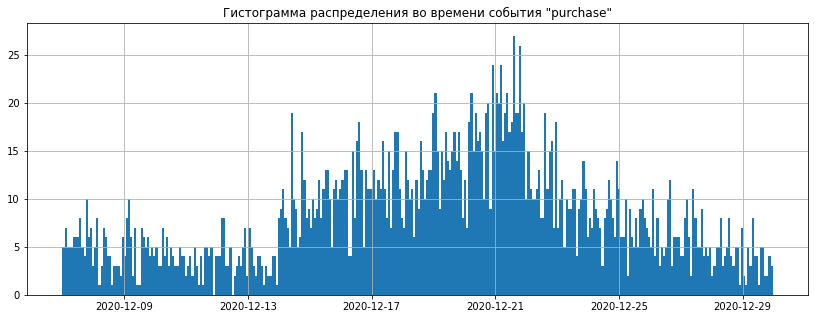

In [ ]:
 hist(df)

На гистограмме всплеска активности в момент проведения рекламной акции нет. Куда потратили рекламный бюджет?  
С начала теста по 14 число распределение примерно равно, 14 декабря наблюдается спад с дальнейшим ростом в пике 22 декабря. Каких-либо значимых различий по событиям нет.  
Думаю, что обрезать пользователей по датам маркетинговой компании смысла нет.


<br>Посмотрим таблицу с данными о количестве пользователей на каждом шаге воронки, а также нарисуем саму воронку.

In [ ]:
user  = (df.groupby('event_name').agg({'user_id': 'nunique'})
    .reset_index().sort_values(by = 'user_id',ascending=False).reset_index()
)
del user['index']
#расчет процента на каждом шаге от общего количества
user['per_for_all'] = (user['user_id']/df['user_id'].nunique())*100
user = user.reindex([0,1,3,2])
#расчет процента каждого шага, от предыдущего шага
user =  user.assign(per_for_step=user['user_id'].div(user['user_id'].shift()).mul(100))

user

,event_name,user_id,per_for_all,per_for_step
0,login,3050,100.0,NaN
1,product_page,1905,62.5,62.5
3,product_cart,900,29.5,47.2
2,purchase,953,31.2,105.9


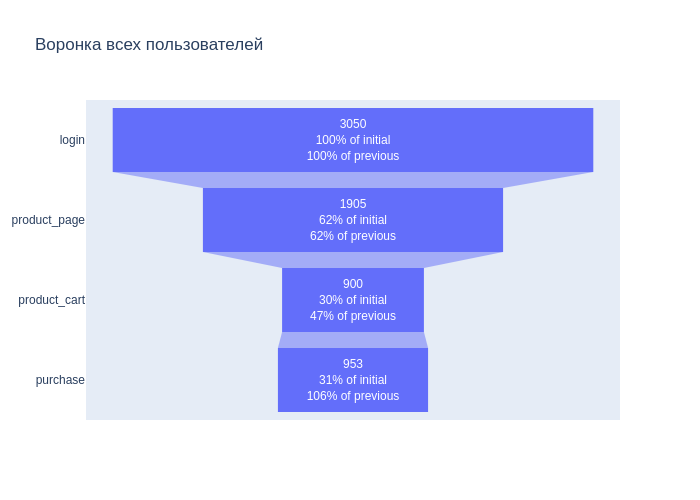

In [ ]:
fig = go.Figure()
fig.add_trace(go.Funnel(
    name='Воронка всех пользователей',
    y = user['event_name'].to_list(),
    x = user['user_id'].to_list() ,
    textposition = "inside",textinfo = "value+percent initial+percent previous"
    ))
fig.update_layout(title="Воронка всех пользователей")
fig.show()

Мы видим что событий `product_cart` меньше, чем `purchase`. Возможно, некоторые покупки были совершены без перехода в корзину, а сразу со странички товара. 
<br> Рассмотрим гистограммы раздельно для *A* группы и *B* группы.

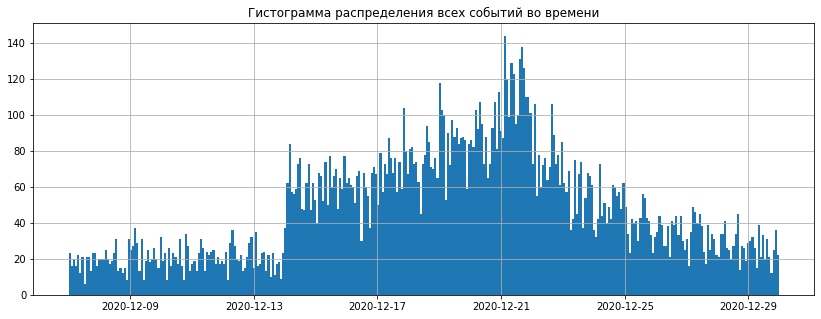

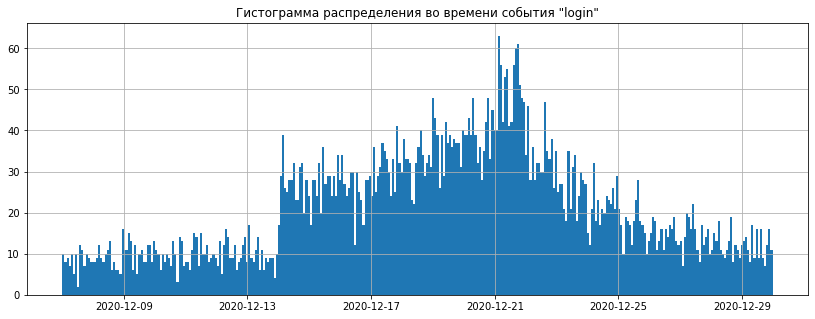

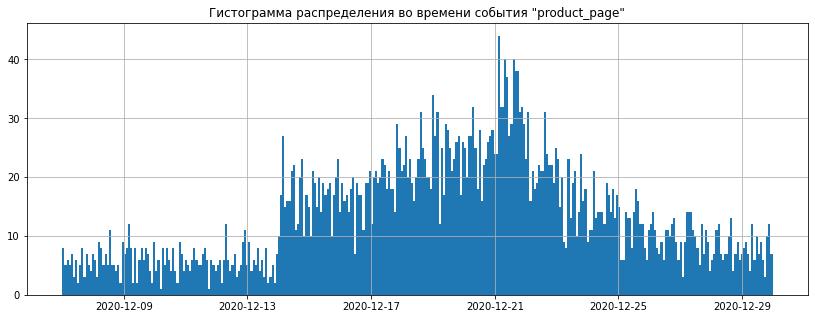

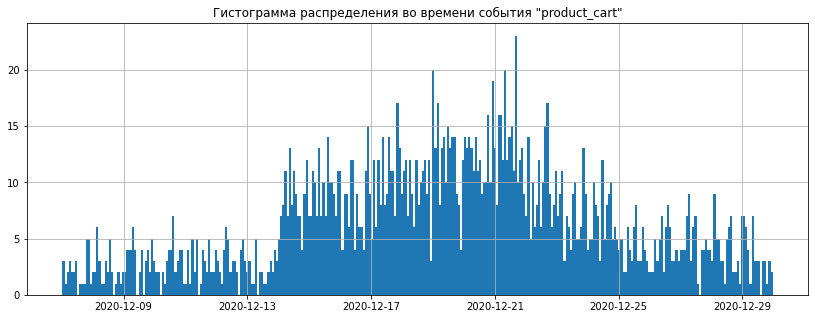

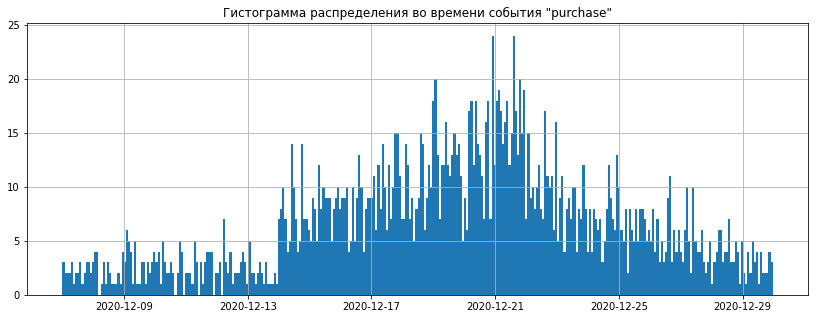

In [ ]:
a_group = df[df['group'] == 'A']
hist(a_group)

Как и в гистограммах с данными об обоих тестах, мы наблюдаем спад 14 декабря и прямой рост с пиком 22 декабря. Далее идет спад действий пользователей. Для всех событий картина, примерно, одинакова.

In [ ]:
a_group_user = (a_group.groupby('event_name').agg({'user_id': 'nunique'})
    .reset_index().sort_values(by = 'user_id',ascending=False).reset_index()
)
#Удаление индекса
del a_group_user['index']
#расчет процента на каждом шаге от общего количества
a_group_user['per_for_all'] = (a_group_user['user_id']/a_group['user_id'].nunique())*100
a_group_user = a_group_user.reindex([0,1,3,2])
#расчет процента каждого шага, от предыдущего шага
a_group_user = a_group_user.assign(per_for_step=a_group_user['user_id'].div(a_group_user['user_id'].shift()).mul(100))

a_group_user

,event_name,user_id,per_for_all,per_for_step
0,login,2279,100.0,NaN
1,product_page,1476,64.8,64.8
3,product_cart,686,30.1,46.5
2,purchase,734,32.2,107.0


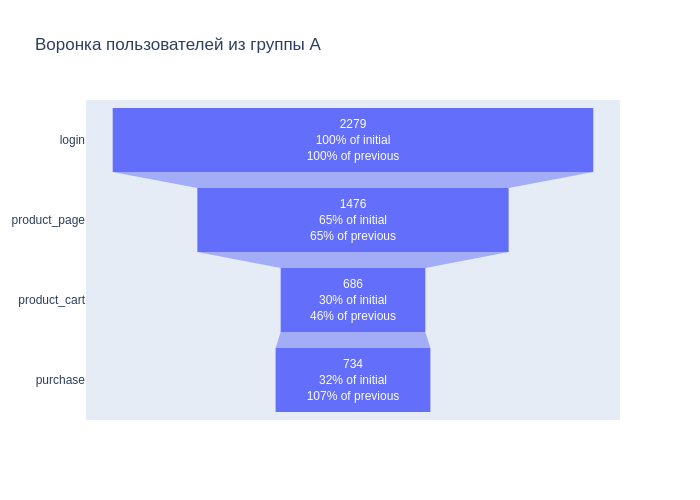

In [ ]:
fig = go.Figure()
fig.add_trace(go.Funnel(
    name='Воронка пользователей',
    y = a_group_user['event_name'].to_list(),
    x = a_group_user['user_id'].to_list() ,
    textposition = "inside",textinfo = "value+percent initial+percent previous" 
    ))
fig.update_layout(title="Воронка пользователей из группы A")
fig.show()

Только 30% пользователей группы *A* дошли до покупки товара. Событий `product_cart` меньше, чем `purchase`, как и в общей воронке по 2м тестовым группам.  
Проведем те же манипуляции с группой *B*.

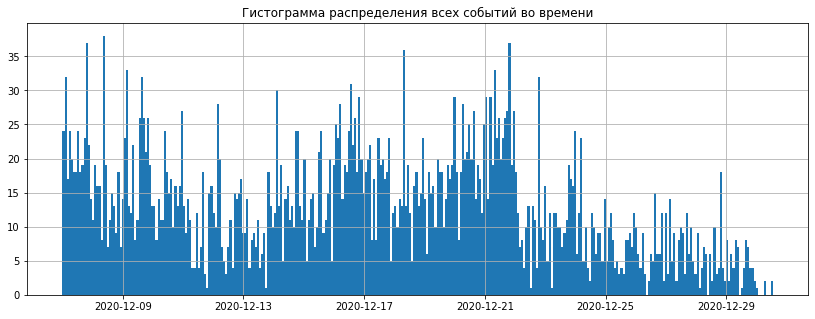

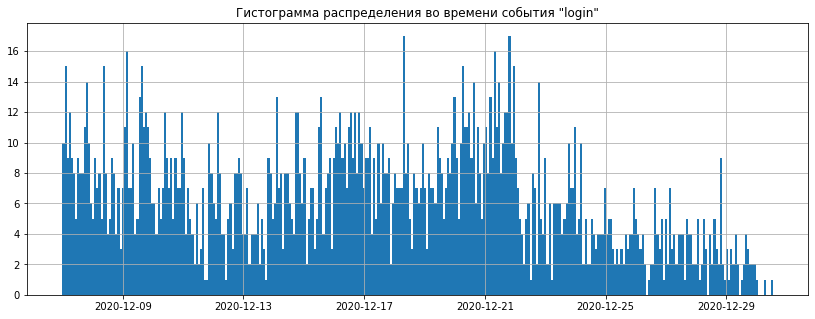

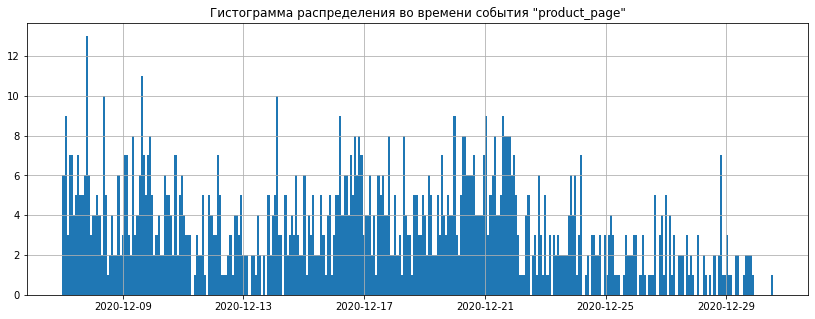

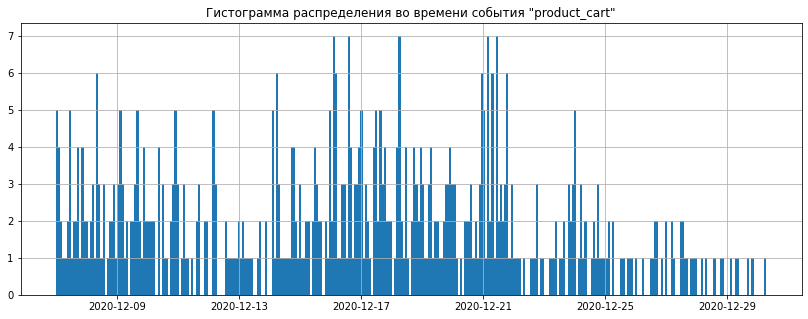

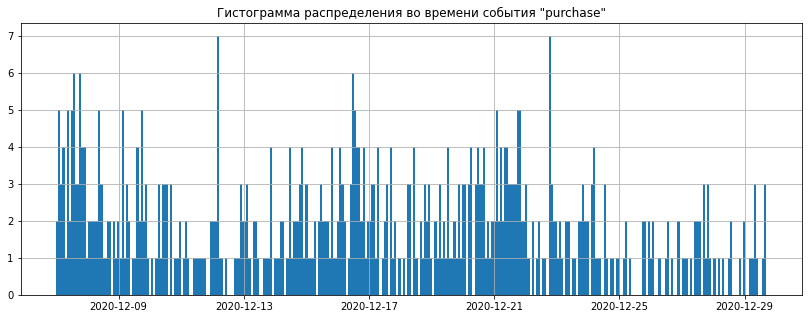

In [ ]:
b_group = df[df['group'] == 'B']
hist(b_group)

Похоже на кардиограмму(мою во время написания этого проекта).
<br> У группы *B* наблюдается обредение на гистограмме, особенно на гистограмме события  *purchase*. Совсем мало покупок. Самый большой спад наблюдается на гистограмме всех событий после 22 числа.

In [ ]:
b_group_user = (b_group.groupby('event_name').agg({'user_id': 'nunique'})
    .reset_index().sort_values(by = 'user_id',ascending=False).reset_index()
)
#Удаление индекса
del b_group_user['index']
#расчет процента на каждом шаге от общего количества
b_group_user['per_for_all'] = (b_group_user['user_id']/b_group['user_id'].nunique())*100
b_group_user = b_group_user.reindex([0,1,3,2])
#расчет процента каждого шага, от предыдущего шага
b_group_user = b_group_user.assign(per_for_step=b_group_user['user_id'].div(b_group_user['user_id'].shift()).mul(100))

b_group_user

,event_name,user_id,per_for_all,per_for_step
0,login,771,100.0,NaN
1,product_page,429,55.6,55.6
3,product_cart,214,27.8,49.9
2,purchase,219,28.4,102.3


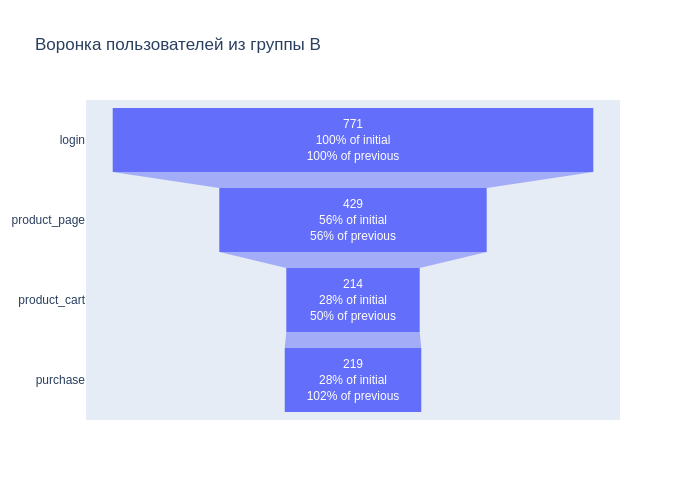

In [ ]:
fig = go.Figure()
fig.add_trace(go.Funnel(
    name='Воронка событий всех пользователей',
    y = b_group_user['event_name'].to_list(),
    x = b_group_user['user_id'].to_list() ,
    textposition = "inside",textinfo = "value+percent initial+percent previous"
))
fig.update_layout(title="Воронка пользователей из группы B")
fig.show()

У группе *B* сразу при переходе на страничку товара теряется 44% пользователей.

In [ ]:
event_user = df.groupby('user_id')['event_name'].count().reset_index()
event_user.columns = ['user_id', 'n_events']
event_user.describe()

,n_events
count,"3,050.0"
mean,6.7
std,3.8
min,1.0
25%,4.0
50%,6.0
75%,9.0
max,28.0


In [ ]:
event_user_a = a_group.groupby('user_id')['event_name'].count().reset_index()
event_user_a.columns = ['user_id', 'n_events']
event_user_a.describe()

,n_events
count,"2,279.0"
mean,7.1
std,3.9
min,1.0
25%,4.0
50%,6.0
75%,9.0
max,24.0


In [ ]:
event_user_b = b_group.groupby('user_id')['event_name'].count().reset_index()
event_user_b.columns = ['user_id', 'n_events']
event_user_b.describe()

,n_events
count,771.0
mean,5.7
std,3.4
min,1.0
25%,3.0
50%,5.0
75%,8.0
max,28.0


Судя по тому, что показал нам метод `describe` распределения вполне нормальные, средние и медианы не имеют больших различий.<br>Построим гистограмму по количество событий в разбивке по группам.

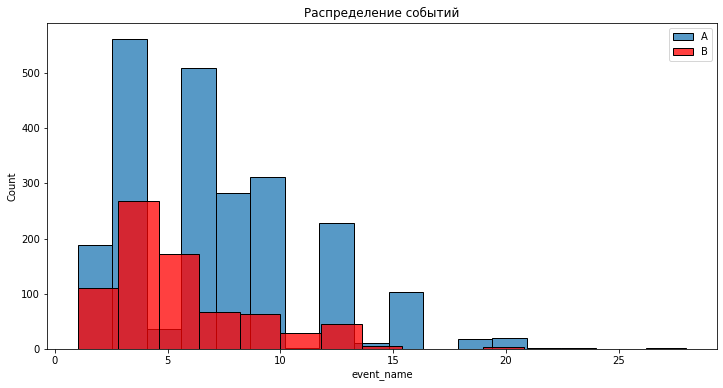

In [ ]:
avg_event_a = a_group.pivot_table(index=['user_id'],values='event_name',aggfunc='count').reset_index()
avg_event_b = b_group.pivot_table(index=['user_id'],values='event_name', aggfunc='count').reset_index()

plt.figure(figsize=(12, 6))
sns.histplot(avg_event_a['event_name'], bins=15)
sns.histplot(avg_event_b['event_name'],bins=15, color = 'r')
plt.legend(labels = ('A', 'B'))
plt.title('Распределение событий')
plt.show()

Распределения похоже по фигуре, однако событий в группе *А* больше, и в среднем в группе *A* пользователи делают на одно действие больше.

### Итоги

Нам пришло срезать большое количество пользователей в связи с пересечением их с параллельным тестом. Так же пользователи не из *EU* были отсечены т.к. по ТЗ, мы должны были рассматривать именно их. Таким образом у нас набралось только 6,6% новых пользователей из EU, когда планировалось 15% и 6 000 пользователей.  
Так же наш тест выполнен с пересечением с маркетинговой новогодней кампанией, что могло повлиять на действие пользователей и искажает наш тест.  
Период остановки теста так же был сокращен, т.к. наши исследуемые пользователи не совершали действий после 30 декабря 2020.  
Разница между группами *A* и *B* большая и составляет 34%.  
Все это говорит о том, что тест проведен не корректно и надо бы переделать, Олег.

## A/B test

Приступим к проверке статистической разницы.

Сформируем таблицу с процентной воронкой от предыдущего шага.

In [ ]:
ab_group_user = a_group_user.merge(b_group_user, on = 'event_name', how='outer')
delta = ab_group_user.drop(['per_for_all_y','per_for_all_x'], axis=1) 
delta.columns = ('event_name','A','per_for_step_A','B','per_for_step_B')

delta

,event_name,A,per_for_step_A,B,per_for_step_B
0,login,2279,NaN,771,NaN
1,product_page,1476,64.8,429,55.6
2,product_cart,686,46.5,214,49.9
3,purchase,734,107.0,219,102.3


Больше всего разница видна в строке с `product_page` - конвертация группы *B* меньше на 9,2%

<br> Перед написанием функции для теста, создадим таблицы, из которой будем вызывать данные.

In [ ]:
#количество пользователей в группа
users_test = df.groupby('group')['user_id'].nunique()
users_test

group
A    2279
B     771
Name: user_id, dtype: int64

In [ ]:
#табличные воронки
ab_group_user = ab_group_user.drop(['per_for_all_y','per_for_all_x','per_for_step_y','per_for_step_x'], axis=1)
ab_group_user.columns = ('event_name','A','B')
ab_group_user = ab_group_user.iloc [1: , :]
ab_group_user

,event_name,A,B
1,product_page,1476,429
2,product_cart,686,214
3,purchase,734,219


Приступим.  
Сформулируем гипотезы:
  
  *H₀*: Статистически значимых различий в доли уникальных посетителей, побывавших на этапе воронки **A** и **B** нет.  
    
*H₁*: Различия в долях уникальных посетителей, побывавших на этапе воронки **A** и **B** статистически значимы.

Напишем и выведем функцию для *Z_test*-а:

In [ ]:
#написание функции
def z_test(gr_1, gr_2, alpha):
    for i in ab_group_user.index:
        p1 = ab_group_user[gr_1][i] / users_test[gr_1]
        # пропорция успехов во второй группе:
        p2 = ab_group_user[gr_2][i] / users_test[gr_2]
        # пропорция успехов в комбинированном датасете:
        p_combined = ((ab_group_user[gr_1][i] + ab_group_user[gr_2][i]) / 
                      (users_test[gr_1] + users_test[gr_2]))
        # разница пропорций в датасетах
        difference = p1 - p2
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/users_test[gr_1] + 1/users_test[gr_2]))
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1) 
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print('{} p-значение: {}'.format(ab_group_user['event_name'][i], p_value))
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print('')
        
z_test("A", "B", (0.05/3))


product_page p-значение: 6.120730626113513e-06
Отвергаем нулевую гипотезу: между долями есть значимая разница

product_cart p-значение: 0.21721122664962245
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

purchase p-значение: 0.048942596376941205
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Таким образом мы провели всего 3 тестов. Отвергли нулевую теорию только в случае с `product_page`, как мы и подметили ранее разница наибольшая именно на этом действии, вот только отрицательная. В двух других тестах отвергнуть нулевую теорию не получилось, поэтому будем считать, что внедрение новой рекомендательной системы оказалось провальным.  
При проверки наших гипотез мы рисковали получить ошибку первого рода ( т.е. зафиксировать разницу между группами, когда её на самом деле нет). Мы ограничили вероятность такого события статистическим уровнем значимости: α - 0,05.  
Т.к. в данном тесте мы имеем дело с множественной проверкой гипотез, итоги могут привести к увеличению ошибок первого рода. Из-за этого была применена поправка Бонферрони, т.е. мы разделили α на количество тестов и применили полученную величину как уровень статистической значимости.

## Выводы

 1) Техническое задание не было полностью соблюдено. В тест не набралось нужного количества пользователей, в контрольной и тестовой группах большая разница в количестве тестируемых - 34%.  
 Последние действия тестируемых пользователей заканчиваются 30 декабря 20, когда тест должен был продлиться до 4 января 21. Тут не ясно, пользователи перестали пользоваться нашими услугами или же произошел сбой и потеря данных.  
 Условие, что аудитория доставляет 15% новых пользователей региона *EU* так же не соблюдается, нам получилось найти их только 6,6% и их не 6 000, как планировалось, а вдвое меньше.  
   
   2) Наш тест проходил одновременно с другим A/B тестом и они не смогли поделить новых пользователей. Часть пользователей мы отсекли из-за этого, так как не можем знать, что именно на них повлияло наш тест или параллельный.  
  Так же, тест умудрились запустить перед новогодними праздниками и пустить в это время рекламную кампанию, посвященную этим событиям. Из-за этого, можно считать, что данные искажены изначально.  
   
   3) После проведения тестирования, мы пришли к выводу что разница между конверсиями есть только на этапе `product_page` - просмотр карточки продукта, при том она не в пользу группы *B*. Поэтому, ожидаемого эффекта в улучшении не менее, чем на 10%, тут точно нет. Таким образом, внедрение новой рекомендательной системы не зарекомендовало себя с хорошей стороны.  
   Считаю, что тест проведен совершенно не корректно, и принимать какие-то решения на его основе, не рекомендую.